# **一个WGAN算法的简单实现**
## **算法概述**
- 一种采用了生成器和判别器进行对抗式训练的算法
    - 生成器模型用于从一个高斯分布采样恢复到一张生成图片的过程
    - 判别器模型用于判别输入的生成图片和真实图片
- 使用了Wasserstein Distance作为生成器和判别器的loss以提高其鲁棒性

论文链接：*https://docs.popo.netease.com/docs/dc6b014dafb241eeb8bd3c7ad382d4ff*

In [1]:
import os,sys
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
from torchsummary import summary

In [2]:
device = 0 if torch.cuda.is_available() else "cpu"
device = "cpu"

In [3]:
DIM = 64
BATCH_SIZE = 50
CRITIC_ITERS = 5
LAMBDA = 5
ITERS = 200000
OUTPUT_DIM = 784

# dataset_name = "mnist"
dataset_name = "fashion_mnist" # 一个时装数据集，以灰度图的形式保存了各种时装的照片

In [4]:
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.transforms import Compose
from datasets import load_dataset
from torchvision import datasets

transformed_dataset = dict()

def transforms_(examples):
    examples["pixel_values"] = [transform(image.convert("L")) for image in examples["image"]]
    del examples["image"]
    return examples

try:
    dataset = load_dataset(dataset_name)
except Exception as e:
    print(e)
    
transform = Compose([
transforms.RandomHorizontalFlip(),
transforms.ToTensor(),
])
transformed_dataset = dataset.with_transform(transforms_).remove_columns("label")
    
train_loader = DataLoader(transformed_dataset['train'], batch_size=BATCH_SIZE, shuffle=True)

Found cached dataset fashion_mnist (/home/ygq/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1)


  0%|          | 0/2 [00:00<?, ?it/s]

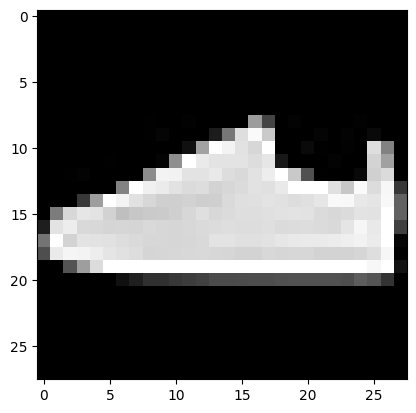

In [5]:
import matplotlib.pyplot as plt
sample = next(iter(train_loader))['pixel_values'].data.numpy()
plt.imshow(sample[0,0,:,:], cmap="gray")
plt.show()

In [6]:
#构建生成器模型
class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        
        self.preprocess = nn.Sequential(
            nn.Linear(128, 4*4*4*DIM),
            nn.ReLU(True),
        )
        self.block1 = nn.Sequential(
            nn.ConvTranspose2d(4*DIM, 2*DIM, 5),
            nn.ReLU(True),
        )
        self.block2 = nn.Sequential(
            nn.ConvTranspose2d(2*DIM, DIM, 5),
            nn.ReLU(True),
        )
        self.deconv_out = nn.ConvTranspose2d(DIM, 1, 8, stride=2)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, input):
        output = self.preprocess(input)
        output = output.view(-1, 4*DIM, 4 , 4)
        output = self.block1(output)
        # output = output[:, :, :7, :7]
        # 改成插值法进行特征裁剪效果差不多
        output = F.interpolate(output,[7,7])
        output = self.block2(output)
        output = self.deconv_out(output)
        output = self.sigmoid(output)
        return output.view(-1, OUTPUT_DIM)
    
generator = Generator().to(device)
summary(generator,(128,), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 4096]         528,384
              ReLU-2                 [-1, 4096]               0
   ConvTranspose2d-3            [-1, 128, 8, 8]         819,328
              ReLU-4            [-1, 128, 8, 8]               0
   ConvTranspose2d-5           [-1, 64, 11, 11]         204,864
              ReLU-6           [-1, 64, 11, 11]               0
   ConvTranspose2d-7            [-1, 1, 28, 28]           4,097
           Sigmoid-8            [-1, 1, 28, 28]               0
Total params: 1,556,673
Trainable params: 1,556,673
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.32
Params size (MB): 5.94
Estimated Total Size (MB): 6.26
----------------------------------------------------------------


In [7]:
#构建判别器模型
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, DIM, 5, stride=2, padding=2),
            nn.ReLU(True),
            nn.Conv2d(DIM, 2*DIM, 5, stride=2, padding=2),
            nn.ReLU(True),
            nn.Conv2d(2*DIM, 4*DIM, 5, stride=2, padding=2),
            nn.ReLU(True),
        )
        self.output = nn.Linear(4*4*4*DIM, 1)
    
    def forward(self, input):
        input = input.view(-1, 1, 28, 28)
        out = self.main(input)
        out = out.view(-1,4*4*4*DIM)
        out = self.output(out)
        return out.view(-1)

discriminator = Discriminator().to(device)
summary(discriminator, (1,784),device=device)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           1,664
              ReLU-2           [-1, 64, 14, 14]               0
            Conv2d-3            [-1, 128, 7, 7]         204,928
              ReLU-4            [-1, 128, 7, 7]               0
            Conv2d-5            [-1, 256, 4, 4]         819,456
              ReLU-6            [-1, 256, 4, 4]               0
            Linear-7                    [-1, 1]           4,097
Total params: 1,030,145
Trainable params: 1,030,145
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.35
Params size (MB): 3.93
Estimated Total Size (MB): 4.28
----------------------------------------------------------------


In [8]:
import numpy as np
import matplotlib.pyplot as plt
def generate_image(frame, net):
    noise = torch.randn(1, 128).to(device)
    with torch.no_grad():
        sample = net(noise)
    sample = sample.view(1, 28, 28).squeeze(0)
    sample = sample.cpu().data.numpy()

    plt.imshow(sample, cmap='gray')
    plt.show()

    
def calc_gradient_penalty(netD, real_data, fake_data):
    alpha = torch.rand(BATCH_SIZE, 1)
    alpha = alpha.expand(real_data.size()).to(device)
    interpolates = alpha * real_data + (1-alpha) * fake_data
    interpolates.requires_grad = True
    disc_interpolates = netD(interpolates)
    gradients = autograd.grad(disc_interpolates, interpolates, 
                             grad_outputs=torch.ones(disc_interpolates.size()).to(device),
                             create_graph=True, retain_graph=True, only_inputs=True)[0]
    
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * LAMBDA
    return gradient_penalty

G_loss is -11.93985366821289
D_loss is -10.102824211120605


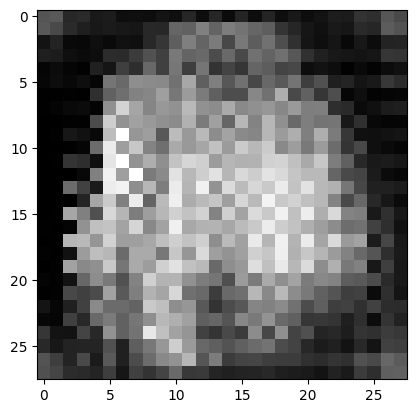

G_loss is -10.242581367492676
D_loss is -7.570048809051514


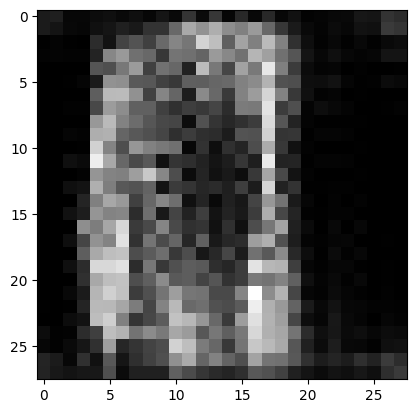

In [ ]:
netG = Generator().to(device)
netD = Discriminator().to(device)

optimizerD = optim.RMSprop(netD.parameters(), lr=1e-4)
optimizerG = optim.RMSprop(netG.parameters(), lr=1e-4)

for iteration in range(ITERS):
    netD.train()
    for iter_d in range(CRITIC_ITERS):
        optimizerD.zero_grad()
        real_data = next(iter(train_loader))['pixel_values'].view((-1, 784)).to(device)
        # print(real_data['pixel_values'].shape)
        D_real = netD(real_data)
        D_real = -D_real.mean()
        D_real.backward()

        noise = torch.randn(BATCH_SIZE, 128).to(device)
        with torch.no_grad():
            fake_data = netG(noise)
        D_fake = netD(fake_data)
        D_fake = D_fake.mean()
        D_fake.backward()

        gradient_penalty = calc_gradient_penalty(netD, real_data.data, fake_data.data)
        gradient_penalty.backward()

        D_cost = D_fake + D_real + gradient_penalty
        Wasserstein_D = D_real - D_fake
        optimizerD.step()
    optimizerG.zero_grad()
    noise = torch.randn(BATCH_SIZE, 128).to(device)
    fake = netG(noise)
    netD.eval()
    G_loss = netD(fake)
    G_loss = -G_loss.mean()
    G_loss.backward()
    optimizerG.step()
    
    
    if iteration % 100 == 99:
        print(f"G_loss is {G_loss.item()}")
        print(f"D_loss is {D_cost.item()}")
        
        generate_image(iteration, netG)

In [2]:
x = 10
y = 6
z = x - y if y==5 else 4
print(z)

4
